# Learning and causality

| | | |
|-|-|-|
|[ ![Creative Commons License](images/cc4.png)](http://creativecommons.org/licenses/by-nc/4.0/) |[ ![aGrUM](images/logoAgrum.png)](https://agrum.org) |[ ![interactive online version](images/atbinder.svg)](https://agrum.gitlab.io/extra/agrum_at_binder.html)

In [1]:
import pyagrum as gum
import pyagrum.lib.notebook as gnb

## Model

Let's assume a process $X_1\rightarrow Y_1$ with a control on $X_1$ by $C_a$ and a parameter $P_b$ on $Y_1$.

In [2]:
bn = gum.fastBN("Ca->X1->Y1<-Pb")
bn.cpt("Ca").fillWith([0.8, 0.2])
bn.cpt("Pb").fillWith([0.3, 0.7])

bn.cpt("X1")[:] = [[0.9, 0.1], [0.1, 0.9]]

bn.cpt("Y1")[{"X1": 0, "Pb": 0}] = [0.8, 0.2]
bn.cpt("Y1")[{"X1": 1, "Pb": 0}] = [0.2, 0.8]
bn.cpt("Y1")[{"X1": 0, "Pb": 1}] = [0.6, 0.4]
bn.cpt("Y1")[{"X1": 1, "Pb": 1}] = [0.4, 0.6]

gnb.flow.row(bn, *[bn.cpt(x) for x in bn.nodes()])

Actually the process is duplicated in the system but the control $C_a$ and the parameter $P_b$ are shared.

In [3]:
bn.add("X2", 2)
bn.add("Y2", 2)
bn.addArc("X2", "Y2")
bn.addArc("Ca", "X2")
bn.addArc("Pb", "Y2")

bn.cpt("X2").fillWith(bn.cpt("X1"), ["X1", "Ca"])  # copy cpt(X1) with the translation X2<-X1,Ca<-Ca
bn.cpt("Y2").fillWith(bn.cpt("Y1"), ["Y1", "X1", "Pb"])  # copy cpt(Y1) with translation Y2<-Y1,X2<-X1,Pb<-Pb

gnb.flow.row(bn, bn.cpt("X2"), bn.cpt("Y2"))

## Simulation of the data

The process is partially observed : the control has been taken into account. However the parameter has not been identified and therefore is not collected.

In [4]:
# the base will be saved in completeData="out/complete_data.csv", observedData="out/observed_data.csv"

completeData = "out/complete_data.csv"
observedData = "out/observed_data.csv"

# generating complete date with pyAgrum
size = 35000
# gum.generateSample(bn,5000,"data.csv",random_order=True)
generator = gum.BNDatabaseGenerator(bn)
generator.setRandomVarOrder()
generator.drawSamples(size)
generator.toCSV(completeData)

In [5]:
# selecting some variables using pandas
import pandas as pd

f = pd.read_csv(completeData)
keep_col = ["X1", "Y1", "X2", "Y2", "Ca"]  # Pb is removed
new_f = f[keep_col]
new_f.to_csv(observedData, index=False)

We will use now a database <tt>fixed_observed_data.csv</tt>. While both databases originate from the same process (the 
cell above), the use of <tt>fixed_observed_data.csv</tt> instead of <tt>observed_data.csv</tt> is made to guarantee a deterministic and stable  behavior for the rest of the notebook.


In [6]:
fixedObsData = "res/fixed_observed_data.csv"

## statistical learning

Using a classical statistical learning method, one can approximate a model from the observed data.

In [7]:
learner = gum.BNLearner(fixedObsData)
learner.useGreedyHillClimbing()
bn2 = learner.learnBN()
bn2

(pyagrum.BayesNet@0x154f71400) BN{nodes: 5, arcs: 5, domainSize: 32, dim: 11, mem: 176o}

## Evaluating the impact of $X2$ on $Y1$

Using the database, a question for the user is to evaluate the impact of the value of $X2$ on $Y1$.

In [8]:
target = "Y1"
evs = "X2"
ie = gum.LazyPropagation(bn)
ie2 = gum.LazyPropagation(bn2)
p1 = ie.evidenceImpact(target, [evs])
p2 = gum.Tensor(p1).fillWith(ie2.evidenceImpact(target, [evs]), [target, evs])
errs = (p1 - p2) / p1
quaderr1 = (errs * errs).sum()
gnb.flow.row(
  p1,
  p2,
  errs,
  rf"$${100 * quaderr1:3.5f}\%$$",
  captions=["in original model", "in learned model", "relative errors", "quadratic relative error"],
)

## Evaluating the causal impact of $X2$ on $Y1$ with the learned model

The statistician notes that the change wanted by the user to apply on $X_2$ is not an observation but rather an intervention.

In [9]:
import pyagrum.causal as csl
import pyagrum.causal.notebook as cslnb

model = csl.CausalModel(bn)
model2 = csl.CausalModel(bn2)

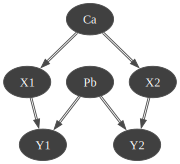

In [10]:
cslnb.showCausalModel(model)

In [11]:
gum.config["notebook", "graph_format"] = "svg"
cslnb.showCausalImpact(model, on=target, doing={evs})
cslnb.showCausalImpact(model2, on=target, doing={evs})

Unfortunately, due to the fact that $P_a$ is not learned, the computation of the causal impact still is imprecise.

In [12]:
_, impact1, _ = csl.causalImpact(model, on=target, doing={evs})
_, impact2orig, _ = csl.causalImpact(model2, on=target, doing={evs})

impact2 = gum.Tensor(p2).fillWith(impact2orig, ["Y1", "X2"])
errs = (impact1 - impact2) / impact1
quaderr2 = (errs * errs).sum()
gnb.flow.row(
  impact1,
  impact2,
  errs,
  rf"$${100 * quaderr2:3.5f}\%$$",
  captions=[
    r"$P( Y_1 \mid \hookrightarrow X_2)$ <br/>in original model",
    r"$P( Y_1 \mid \hookrightarrow X_2)$  <br/>in learned model",
    " <br/>relative errors",
    " <br/>quadratic relative error",
  ],
)

Just to be certain, we can verify that in the original model, $P( Y_1 \mid \hookrightarrow X_2)=P(Y_1)$

In [13]:
gnb.flow.row(
  impact1,
  ie.evidenceImpact(target, []),
  captions=[r"$P( Y_1 \mid \hookrightarrow X_2)$ <br/>in the original model", "$P(Y_1)$ <br/>in the original model"],
)

## Causal learning and causal impact

Some learning algorthims such as MIIC (Verny et al., 2017) aim to find the trace of latent variables in the data !

In [14]:
learner = gum.BNLearner(fixedObsData)
learner.useMIIC()
bn3 = learner.learnBN()

In [15]:
gnb.flow.row(
  bn,
  bn3,
  f"$${[(bn3.variable(i).name(), bn3.variable(j).name()) for (i, j) in learner.latentVariables()]}$$",
  captions=["original model", "learned model", "Latent variables found"],
)

A latent variable (common cause) has been found in the data betwenn $Y1$ and $Y2$ !

Therefore we can build a causal model taking into account this latent variable found by MIIC.

In [16]:
model3 = csl.CausalModel(bn2, [("L1", ("Y1", "Y2"))])
cslnb.showCausalImpact(model3, target, {evs})

Then at least, the statistician can say that $X_2$ has no impact on $Y_1$ from the data. The error is just due to the approximation of the parameters in the database.

In [17]:
_, impact1, _ = csl.causalImpact(model, on=target, doing={evs})
_, impact3orig, _ = csl.causalImpact(model3, on=target, doing={evs})

impact3 = gum.Tensor(impact1).fillWith(impact3orig, ["Y1"])
errs = (impact1 - impact3) / impact1
quaderr3 = (errs * errs).sum()
gnb.flow.row(
  impact1,
  impact3,
  errs,
  rf"$${100 * quaderr3:3.5f}\%$$",
  captions=["in original model", "in learned model", "relative errors", "quadratic relative error"],
)

In [18]:
print("In conclusion :")
print(rf"- Error with spurious structure and classical inference : {100 * quaderr1:3.5f}%")
print(rf"- Error with spurious structure and do-calculus : {100 * quaderr2:3.5f}%")
print(rf"- Error with correct causal structure and do-calculus : {100 * quaderr3:3.5f}%")

In conclusion :
- Error with spurious structure and classical inference : 0.07722%
- Error with spurious structure and do-calculus : 0.17362%
- Error with correct causal structure and do-calculus : 0.01588%
